In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
"""
Stage 2 : GM is present , SM is removed 
"""

# Find the closest point to the parent scribble line . 
from numpy import random 
from scipy.spatial import distance
import imageio
import sys
import os 
import cv2
import copy 
import json 
import random
from google.colab.patches import cv2_imshow

from json import JSONEncoder
import argparse

import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from skimage import io

import scipy.spatial.distance as dist 
from skimage.filters import threshold_otsu, threshold_niblack,threshold_sauvola
from skimage.morphology import skeletonize,medial_axis


# All required libraries to import .. 
import time
import numpy as np
from PIL import Image
import sys
from skimage import measure
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import distance
import itertools
import numba
import itertools
import glob
import csv 
import json 
from collections import OrderedDict
# from google.colab.patches import cv2_imshow
from os import listdir
from os.path import isfile, join
import copy 
import scipy.spatial.distance as dist 
from skimage.filters import (threshold_otsu, threshold_niblack,threshold_sauvola)
from scipy.interpolate import splprep, splev
import numpy as numpy


# Numpy class for handling JSON writes .. 
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# Config  
isClosed = True
thickness = 2
color1 = (255, 0, 0)
color2 = (0, 0, 255)
color3 = (0, 255,0)
color4 = (128,128,128)
colorblack = 0 
colorwhite = 1 
scribbleThickness=5


def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    # set bg label to black
    labeled_img[label_hue==0] = 0
    return(labeled_img)

def ccl(img,conn=8,inv=False):
    # Convert it to 255 scale 
    img = np.asarray(img,dtype=np.int32)
    if((np.max(img))!=255):
        img = img/np.max(img)
        img = 255*img
    # Inverting it 
    if(inv):
        bin_uint8 = (255-img).astype(np.int32)
    else:
        bin_uint8 = np.asarray(img,dtype=np.uint8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_uint8,conn,cv2.CV_32S)
    markedImage = imshow_components(labels)
    return markedImage,num_labels, labels, stats, centroids
    
# node -> centroid , nodes = list of scribblePoints 
def closest_node(node, nodes):
    node = np.asarray(node)
    nodes = np.asarray(nodes).reshape(-1,2)
    closest_index = distance.cdist([node], nodes).argmin()
    return nodes[closest_index]

# Collate the stats-centroids-labels in correct fashion , and apply areaThreshold 
def processStats(image,labels,stats,centroids,areaThreshold=70,vis=False):
  H,W,C=image.shape
  image1=image.copy()
  stats = np.asarray(stats,dtype=np.int32).tolist()
  centroids = np.asarray(centroids,dtype=np.int32).tolist()
  # label,x,y,w,h,centroid
  stats = [ [i]+stat+[centroids[i][0],centroids[i][1]] for i,stat in enumerate(stats)]
  stats = sorted(stats,key=lambda x: x[5],reverse=True)
  # Remove the first two label (bg) 
  stats.pop(0)
  stats.pop(0)
  stats = [ stat for stat in stats if stat[5]>areaThreshold]
  netstats=[]
  for i,lab in enumerate(stats):
      trueLabel = lab[0]
      labelMask = np.zeros((H,W,1))
      labelMask[labels==trueLabel]=255
      labelMask=np.uint8(labelMask)
      # Find contour for this .
      contours, hierarchy = cv2.findContours(labelMask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      polygon=[contours[0]]
      
      x = lab[1]
      y = lab[2]
      w = lab[3]
      h = lab[4]
      cX = lab[-2]
      cY = lab[-1]

      # label,polygon,centroidx,centroidy
      netstats.append([trueLabel,polygon,cX,cY])

      if vis : 
        # Draw the bbox associated with the components 
        image=cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        # Mark the centroid of these components 
        image=cv2.circle(image, (int(cX), int(cY)),5,(0,0,255), -1)
        # cv2_imshow(image)

  return netstats 

# newstats=processStats(cImg,labels,stats,centroids)

# Pseudo Scribbles 
def generatePseudoScribble(scribble, gap, isUp):
  psuedoScribble=[]
  if (isUp):
    gap = -gap
  for i in range(len(scribble)):
      psuedoScribble.append([scribble[i][0],scribble[i][1]+gap])
  return psuedoScribble

# Region Mask for each scribble 
def regionMask(scribble,img,gap=30):
  # Generate Pseudo Scribbles 
  upperPseudoScribbles=generatePseudoScribble(scribble, gap, isUp=True)
  lowerPseudoScribbles=generatePseudoScribble(scribble, gap, isUp=False)
  N = len(lowerPseudoScribbles)
  bottom =  np.flipud(np.asarray(lowerPseudoScribbles,dtype=np.int32))
  top = np.asarray(upperPseudoScribbles,dtype=np.int32)
  region = np.concatenate((top,bottom))
  polynomialgon = np.zeros((img.shape[0],img.shape[1]))
  polynomialgon=cv2.fillPoly(polynomialgon, [region], color=[1])
  rmask = np.expand_dims(polynomialgon,axis=2)
  return rmask

def genDiacriticMap(binImage,scribbles,gap,thickness=5):
  newScribbles=[]
  # Take the binary image 
  vcanvas=np.zeros((binImage.shape[0],binImage.shape[1],3))
  for scribble in scribbles:
    canvas=cv2.polylines(binImage.copy(),np.int32([scribble]),False,(255,255,255),thickness)
    rMask = regionMask(scribble,canvas,gap)
    netRegion = np.uint8(canvas*(rMask))
    netRegion=cv2.cvtColor(netRegion, cv2.COLOR_BGR2GRAY)
    cImg, num_labels,labels,stats,centroids= ccl(netRegion,conn=4,inv=False)
    netstats = processStats(cImg,labels,stats,centroids,areaThreshold=70,vis=False)
    # Connected points 
    connectedPoints=[]
    for i,stat in enumerate(netstats):
      basePoint = [stat[-2],stat[-1]]
      basePolygon = stat[1][0]
      sclosestPoint=list(closest_node(basePoint,scribble))
      closestPoint = list(closest_node(sclosestPoint,basePolygon))
      connectedPoints.append({'basePoint':sclosestPoint,'connectPoint':closestPoint})
    
    # Map plotting 
    for i,pdict in enumerate(connectedPoints):
      startPoint = pdict['basePoint']
      endPoint = pdict['connectPoint']
      vcanvas = cv2.line(vcanvas, startPoint, endPoint,(255,255,255),thickness)
    vcanvas=cv2.polylines(vcanvas,np.int32([scribble]),False,(255,255,255),thickness)

  # print('New-Scribble-Map')
  # cv2_imshow(vcanvas)
  # Enhanced Binary Map 
  # print('New-DM-InfusedMap')
  bMapNew = 255*cv2.bitwise_or(vcanvas/255,binImage/255)
  # cv2_imshow(bMapNew)
  return vcanvas,bMapNew



"""# Seam Carving : Utils """

# Mark scribble on images.
def markScribbleList(img,scribbleList,thickness=5):
    # blank canvas 
    scribbleThickness=5
    h,w,c=img.shape
    for i,scribble in enumerate(scribbleList):
        img=cv2.polylines(img,np.int32([scribble]),False,(255,255,255),scribbleThickness)
    return(img)


# Mark scribble on images.
def markScribbleListGray(img,scribbleList,thickness=5):
    # blank canvas 
    h,w=img.shape
    scribbleThickness=5
    for i,scribble in enumerate(scribbleList):
        img=cv2.polylines(img,np.int32([scribble]),False,(255,255,255),scribbleThickness)
    return(img)

def Reverse(lst):
    new_lst = lst[::-1]
    return new_lst

def regionGeneration(img,upperSeam,lowerSeam,display=False):
    upperSeam=upperSeam.reshape((upperSeam.shape[0],1,2))
    lowerSeam=lowerSeam.reshape((lowerSeam.shape[0],1,2))
    lowerSeam = np.flipud(lowerSeam)
    region =   np.concatenate((upperSeam, lowerSeam))
    if(display and img is not None):
        polynomialgon = np.zeros(img.shape)
        cv2.fillPoly(polynomialgon, [region], color=[255,255,255])
    return(region)


def polyGeneration(img,upperSeam,lowerSeam,scribble=None,display=False):

    firstPoint = np.asarray(scribble[0]).tolist()
    lastPoint = np.asarray(scribble[-1]).tolist()

  
    xLimit = np.maximum(lastPoint[0],firstPoint[0])+50
    yLimit = np.maximum(lastPoint[1],firstPoint[1])+50


    upperSeam = [ point for point in upperSeam if(point[0]< xLimit and point[1]<yLimit) ] 
    lowerSeam = [ point for point in lowerSeam if(point[0]< xLimit and point[1]<yLimit) ] 


    upperSeam=np.asarray(upperSeam,dtype=np.int32)
    lowerSeam=np.asarray(lowerSeam,dtype=np.int32)

    upperSeam=upperSeam.reshape((upperSeam.shape[0],1,2))
    lowerSeam=lowerSeam.reshape((lowerSeam.shape[0],1,2))

    region =  np.concatenate((upperSeam, lowerSeam))
    if(display and img is not None):
        canvas = copy.deepcopy(img)
        canvas = cv2.drawContours(canvas,[region],0,(255,0,0),2)
        #cv2_imshow(canvas)
        
    return(region)


def converttoPolySeam(seams):
    x_axis = np.expand_dims(np.array(range(0, len(seams[0]))), -1)
    seams = [np.concatenate((x, np.expand_dims(seam, -1)), axis=1) for seam, x in zip(seams, itertools.repeat(x_axis))]
    seamfinal =np.asarray(seams[0])
    return seamfinal

"""# Seams : Helper Function  """

from numpy import array, sqrt, max, zeros_like, argmin,ones, stack, rot90
from scipy.signal import convolve2d, gaussian
from numba import jit
from collections import deque
from sys import maxsize

from PIL import Image

"""algorithm.py"""
sobel_kernels = {
    'x': array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]),
    'y': array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])
}

gaussian_kernel = (1/16) * array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
])

DIAGONAL_LEFT = np.intp(1)
DOWN = np.intp(2)
DIAGONAL_RIGHT = np.intp(3)


def apply_sobel(image: array):
    blurred = convolve2d(image, gaussian_kernel, mode='same', boundary='symm')
    grad_x = convolve2d(
        blurred, sobel_kernels['x'], mode='same', boundary='symm')
    grad_y = convolve2d(
        blurred, sobel_kernels['y'], mode='same', boundary='symm')
    grad = sqrt(grad_x * grad_x + grad_y * grad_y)
    normalised_grad = grad * (255.0 / max(grad))
    return normalised_grad


# @numba.autojit(warn=False)
@jit
def is_in_image(position: tuple, rows: int, cols: int) -> bool:
    row, col = position
    return row >= 0 and col >= 0 and row < rows and col < cols


def generatePseudoScribble(scribble, gap, isUp):
  psuedoScribble=[]
  if (isUp):
    gap = -gap
  for i in range(len(scribble)):
      psuedoScribble.append([scribble[i][0],scribble[i][1]+gap])
  return psuedoScribble


# @numba.autojit(warn=False)
@jit
def compute_optimal_seam(energy, region):
    energy[np.where(region==0)]=255
    rows, cols = energy.shape
    infinity = maxsize / 10
    dp = energy.copy()

    next_seam_position = zeros_like(dp, dtype=np.intp)

    for col in range(cols):
        dp[rows - 1][col] = energy[rows-1][col]

    for row in range(rows - 2, -1, -1):
        for col in range(cols):
            optimal_adjacent_cost = infinity
            optimal_choice = -1
            adjacents = [
                ((row + 1, col - 1), DIAGONAL_LEFT),
                ((row + 1, col), DOWN),
                ((row + 1, col + 1), DIAGONAL_RIGHT)
            ]
            for (adjacent, choice) in adjacents:
                adjacent_row, adjacent_col = adjacent
                if not is_in_image(adjacent, rows, cols):
                    continue
                if dp[adjacent_row][adjacent_col] < optimal_adjacent_cost:
                    optimal_adjacent_cost = dp[adjacent_row][adjacent_col]
                    optimal_choice = choice

            next_seam_position[row][col] = optimal_choice
            dp[row][col] = energy[row][col] + optimal_adjacent_cost

    seam_start_col = argmin(dp[0, :])
    seam_start = [0, seam_start_col]
    seam_cost = dp[0][seam_start_col]
    return (seam_start, seam_cost, next_seam_position)

"""carver.py"""

@jit
def trace_seam(original_image, energy_image, seam_start, next_seam_position, seam, endSeam):
    seam_pos = seam_start
    while True:
        row, col = seam_pos
        seam.append([original_image.shape[1]-col, row])
        if (next_seam_position[row][col] == 0 or row>endSeam):
            break
        if (next_seam_position[row][col] == DIAGONAL_LEFT):
            seam_pos = [row + 1, col - 1]
        elif (next_seam_position[row][col] == DIAGONAL_RIGHT):
            seam_pos = [row + 1, col + 1]
        else:
            seam_pos = [row + 1, col]


def get_energy_image(image_to_crop):
    grayscale_to_crop = cv2.cvtColor(image_to_crop, cv2.COLOR_RGB2GRAY)
    grayscale_to_crop_energy = apply_sobel((grayscale_to_crop))
    return grayscale_to_crop_energy

def get_energy_image_with_mask(image_to_crop, mask):
    grayscale_to_crop = cv2.cvtColor(image_to_crop, cv2.COLOR_RGB2GRAY)
    grayscale_to_crop_energy = apply_sobel(grayscale_to_crop)
    grayscale_to_crop_energy = np.int32(0.8*grayscale_to_crop_energy + 0.2*np.float32(mask))
    return grayscale_to_crop_energy

def get_energy_image_with_two_masks(image_to_crop, mask1, mask2):
    grayscale_to_crop = cv2.cvtColor(image_to_crop, cv2.COLOR_RGB2GRAY)
    grayscale_to_crop_energy = apply_sobel(grayscale_to_crop)
    grayscale_to_crop_energy = np.int32(0.6*grayscale_to_crop_energy + 0.4*np.float32(mask1))
    grayscale_to_crop_energy[np.where(mask2!=0)]=255
    return grayscale_to_crop_energy

def get_energy_in_rgb(energy_grayscale):
    # print(energy_grayscale.shape)
    # x = cv2.cvtColor(energy_grayscale, cv2.COLOR_GRAY2RGB)
    x = np.repeat(np.expand_dims(energy_grayscale, axis=2), 3, axis=2) # Convert the numpy array to a CV2 RGB image rgb_image = cv2.cvtColor(rgb_array, cv2.COLOR_BGR2RGB)
    return x

# def get_energy_in_rgb(energy_grayscale: array):
#     return array(Image.fromarray(energy_grayscale).convert('RGB'))

def carve_column_and_mark_seam(original_image: array, energy_image: array, seam_start: list, next_seam_position: tuple, endSeam: int):
    seam = list()
    trace_seam(
        original_image, energy_image, seam_start, next_seam_position, seam, endSeam
    )
    return original_image, energy_image, seam


def crop_column(original_image, energy_image, points: list, regions: list, endPoints: list):
    image_energy = energy_image.copy()
    seams=list()
    for i in range(len(regions)):
      (seam_start, seam_cost, next_seam_position) = compute_optimal_seam(image_energy.copy(), regions[i])
      seam_start = [points[i][1],image_energy.shape[1]-points[i][0]]
      original, energy, seam = carve_column_and_mark_seam(
          array(original_image),
          get_energy_in_rgb(array(energy_image)),
          seam_start,
          next_seam_position, endPoints[i+1][0]
      )
      seams.append(seam)

    original_image = original.copy()
    energy_image = energy.copy()

    return original_image, energy_image, seams


def crop_row(original_image, energy_image, points: list, regions: list, endPoints: list):
    # transposed_original_image = original_image.rotate(3*90, expand=True)
    transposed_original_image = np.rot90(original_image, 3)
    # transposed_energy_image = energy_image.rotate(3*90, expand=True)
    transposed_energy_image = np.rot90(energy_image, 3)
    for i in range(len(regions)):
      reg = regions[i].copy()
      # reg = reg.rotate(3*90, expand=True)
      reg = np.rot90(reg, 3)
      regions[i] = reg.copy()

    marked_original_image, energy_image, seams = crop_column(transposed_original_image, transposed_energy_image, points, regions, endPoints)

    return (
        np.rot90(marked_original_image, 1),
        np.rot90(energy_image, 1),
        seams
    )

def get_energy_image_with_blur_masks(image_to_crop, mask1, mask2, scribbleList):
    grayscale_to_crop = cv2.cvtColor(image_to_crop, cv2.COLOR_RGB2GRAY)
    grayscale_to_crop_energy = apply_sobel(grayscale_to_crop)
    grayscale_to_crop_energy = numpy.int32(0.9*grayscale_to_crop_energy + 0.1*numpy.float32(mask2))
    grayscale_to_crop_energy =markScribbleListGray(grayscale_to_crop_energy,scribbleList)
    return grayscale_to_crop_energy


def crop(original_image, energy_image, points: list, regions: list, endPoints: list):
    marked_original_image = original_image.copy()
    marked_energy_image = energy_image.copy()
    marked_original_image, marked_energy_image, seams = crop_row(marked_original_image, marked_energy_image, points, regions, endPoints)
    return (marked_original_image, marked_energy_image, seams)

"""# Test """

def imgCombiner(img1,img2):

    img1 = img1.astype(np.uint8)
    img2 = img2.astype(np.uint8)

    h1, w1,c1 = img1.shape
    h2, w2,c2 = img2.shape

    #create empty matrix
    vis = np.zeros((h1+h2,np.max(w1,w2),c1)).astype(np.uint8)
    #combine 2 images
    vis[0:h1,0:w1,:3] = img1
    # vis[:h2, w1:w1+w2,:3] = img2
    vis[h1:h1+h2,0:w2,:3]=img2
    return(vis)

'''
GAP Computation Part 
'''

def avgHeight(scribble): 
  scribble = np.asarray(scribble,dtype=np.float32).reshape(-1,2)
  avgY = np.mean(scribble,axis=0)
  val = np.int(np.mean(avgY))
  return val

def sortScribblesGlobal(scribbles):
  scribbleListRaw=[]
  for j,scribble in enumerate(scribbles):
    scribble=np.asarray(scribble)
    s=scribble.reshape(-1,2)
    s=s.tolist()
    s=sorted(s,key=lambda k: [k[0], k[1]])
    scribbleListRaw.append(s)
  scribbleList=sorted(scribbleListRaw,key=lambda k: avgHeight(k),reverse=False)
  return scribbleList


# Get average height
def avgYHeight(scribble): 
  scribble = np.asarray(scribble,dtype=np.float32).reshape(-1,2)
  avgY = np.mean(scribble,axis=0)
  val = np.mean(avgY)
  return val

# Gap 
def getInterlineGap(scribbles,BUFFER=10):
  # sort the scribbles 
  scribbles = sortScribblesGlobal(scribbles)
  avgDist = []
  for i,sc in enumerate(scribbles):
    if i+1 < len(scribbles):
      avgDist.append(np.abs(avgYHeight(scribbles[i])-avgYHeight(scribbles[i+1])))
  avgDist = np.asarray(avgDist,np.float32)
  gap = np.mean(avgDist) + BUFFER
  gap = 35
  return gap 

def extremePoints(c):
    c = np.asarray(c).reshape(-1,1,2)
    startPoint = list(c[c[:, :, 0].argmin()][0])
    endPoint = list(c[c[:, :, 0].argmax()][0])
    return startPoint,endPoint


"""# Seams : Primary Function """
def generateSeams(imgSource,binImage,scribbleList, showImg=False,save=False,omega=0.70):
    
    opt = None 
    if (len(scribbleList)==0):
        print("Error message , No Scribbles are present ...")
        return None,None
    
    orgScribbles=copy.deepcopy(scribbleList)

    initPoints = []
    endPoints = []
    for scribble in scribbleList:
        initPoints.append(scribble[0])
        endPoints.append(scribble[-1])
    

    dists=[]
    verdists=[]
    for i in range(1,len(initPoints)):
      verdists.append(abs(initPoints[i][1]-initPoints[i-1][1]))
     

    gap =  getInterlineGap(scribbleList)
    head = np.int(gap/2)

    regions=[]
    sList = copy.deepcopy(scribbleList)
    imgNow = imgSource

    for i,currscr in enumerate(scribbleList):
        
        seam_current = np.asarray(generatePseudoScribble(scribbleList[i],gap,True))
        seam_next = np.asarray(scribbleList[i])

        seam_current=seam_current.reshape((seam_current.shape[0],1,2))
        seam_next=seam_next.reshape((seam_next.shape[0],1,2))

        seam_next = np.flipud(seam_next)

        region = np.concatenate((seam_current, seam_next))

        polynomialgon = np.zeros((imgNow.shape[0],imgNow.shape[1]))
        cv2.fillPoly(polynomialgon, [region], color=[255])
        regions.append(polynomialgon)


    initPoints = copy.deepcopy(initPoints)
    endPoints = copy.deepcopy(endPoints)
    
    head = 0
    initPoints = [[scribbleList[0][0][0], initPoints[0][1]-head]] + initPoints
    initPoints.append([scribbleList[-1][0][0], initPoints[-1][1]+head])

    endPoints = [[scribbleList[0][-1][0], endPoints[0][1]-head]] + endPoints
    endPoints.append([scribbleList[-1][-1][0], endPoints[-1][1]+head])


    coors=copy.deepcopy(initPoints)
    ends = copy.deepcopy(endPoints)
    
    if (len(coors)==0):
        print('Cannot process furthur')
        return None,None
    
    coors[0][0], coors[0][1] = coors[0][1], coors[0][0]		        
    for i in range(1,len(coors)-1):		   
        coors[i][0], coors[i][1] = coors[i+1][1]-head, coors[i+1][0]

    coors.pop(-1)
    img = binImage.copy()
    thresh = copy.deepcopy(img)

    # Remove vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,35))
    remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    remove_vertical = cv2.cvtColor(remove_vertical,cv2.COLOR_BGR2GRAY)
    # cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cv2.findContours(remove_vertical.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(thresh, [c], -1, (0,0,0), 15)

    img=copy.deepcopy(thresh)

    # First Map - ScribbleMap - Generate via Diacritic Map Function , not from raw scribbles 
    image = markScribbleList(img,scribbleList)

    '''
    # Turn off Diacritic Map 
    dMapNew,bMapNew= genDiacriticMap(img,orgScribbles,gap)
    mask1 = copy.deepcopy(bMapNew)
    '''
    img = copy.deepcopy(thresh)
    image = markScribbleList(img,scribbleList)
    mask1 = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY) 
    mask1 = image.copy()
  
    # Gaussian Blur --Smoothing Map 
    mask2 = cv2.GaussianBlur(mask1,(5, 11), 0)
    mask2 = markScribbleList(mask2,scribbleList)
    mask2 = cv2.cvtColor(mask2.astype(np.uint8),cv2.COLOR_BGR2GRAY)
  

    # image = stack([array(image)]*3,axis=-1)
    # image = Image.fromarray(image, 'RGB')
    # image2 = copy.deepcopy(image)
    image2 = image.copy()

    # original_energy_image = get_energy_image_with_two_masks(image, mask1, mask2)
    original_energy_image = get_energy_image_with_blur_masks(image, mask1, mask2, scribbleList)
    # original_energy_image2 = copy.deepcopy(original_energy_image)
    original_energy_image2 = original_energy_image.copy()
    (marked_original_image, marked_energy_image, seams) = crop(
        image,
        original_energy_image,
        coors, regions, ends)

    img=marked_energy_image.copy()

    seams = np.array(seams)
    seams = seams.squeeze()

    

    if(save or showImg):
        for i in range(len(seams)):
            for j in range(len(seams[i])):
                seams[i][j][0], seams[i][j][1] = seams[i][j][1], seams[i][j][0] 
            # img=cv2.polylines(img,seams[i],False,(0,0,255),2)
            img=cv2.polylines(img,[array(seams[i])],False,(0,0,255),2)
        

        opt = copy.deepcopy(img)
      
    # Results 
    fseams = copy.deepcopy(seams)
    N = len(fseams)
    polygons = []
    srList = Reverse(sList)
        
    return fseams,opt


  
def imageTask(img,bimg,scribbles):
  # bimg = 255 - bimg
  img = np.asarray(img,dtype=np.uint8)
  bimg = np.asarray(bimg,dtype=np.uint8)
  H,W,C = img.shape
  orgScribbles = copy.deepcopy(scribbles)
  scribbleListRaw=[]
  for j,scribble in enumerate(scribbles):
    scribble=np.asarray(scribble,dtype=np.int32).reshape(-1,2)
    s=scribble.tolist()
    s=sorted(s,key=lambda k: [k[0], k[1]])
    scribbleListRaw.append(s)
  # Sorting of scribbles 
  scribbleList=sorted(scribbleListRaw,key=lambda k: [k[0][1], k[0][0]])
  # Final Polygons , Canvas 
  predpolygons,opt = generateSeams(img,bimg,scribbleList, showImg=False)
  if predpolygons is None :
    return None
  return predpolygons

# if __name__ == "__main__":
#     # Fetch args
#     evalDict={'LineAcc':0,'pixelAcc':0,'IoU':0,'HD':0,'AvgHD':0,'HD95':0,'textIoU':0}
#     jsonOutputs=[]
#     binaryDir = '/home2/apoorva2019/BS_Binarised'
#     inferenceJSON = '/home2/apoorva2019/ICDARTest/BL_DATA/BL_TEST/BL_TEST.json'
#     # Read the inference json 
#     with open(inferenceJSON,'r') as f:
#         data = json.load(f)

#     # Test it out for 1 image 
#     inst = data[0]
#     path = inst['imgPath'].replace('./','/home2/apoorva2019/').replace('.tif','.jpg')
#     img = cv2.imread(path)
#     gds = inst['gdPolygons']
#     scribbles = inst['scribbles']
#     imgDims = [img.shape[0],img.shape[1]]
#     _,imgName = os.path.split(path)

#     # Getting the image base name 
#     imgNameBase = imgName.split('.')[0]
#     binaryImageName = imgNameBase+'_binarized.jpg'
#     bimg = cv2.imread(os.path.join(binaryDir,binaryImageName))

#     # Call the function 
#     predPolygons =  imageTask(img,bimg,scribbles)
#     print('GD Polygons : {} Predicted Polygons : {}'.format(len(gds),len(predPolygons)))
#     print('~Completed!')


In [10]:
jsonPath = '/content/drive/MyDrive/I2_TEST.json'
# imagePath = '/content/drive/MyDrive/researchTesting/IIIB-12-306-P2.jpg'

# Read the image 
# image =img1 = cv2.imread(imagePath)
# Read the json 
with open(jsonPath,'r') as f:
    data= json.load(f)

for i,inst in enumerate(data):
  if inst['imgPath'].find('B02-S10-236.jpg')>=0 :
    print(i)
    ind = i 
    break

# imagePath2 = '154.jpg'
imagePath = '/content/drive/MyDrive/test.jpg'
# imagePath = '/content/drive/MyDrive/researchTesting/_data_jain-mscripts_Chandibazaar_chandibajar_0011.2_images_0383.jpg'
print(imagePath)
image =img1 = cv2.imread(imagePath)
bImg = cv2.imread('/content/drive/MyDrive/TestBin.png')

188
/content/drive/MyDrive/test.jpg


In [21]:
netScribbles = data[ind]['scribbles']
polys = imageTask(image,bImg,netScribbles)

<ipython-input-20-aafd39f60b98>:515: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val = np.int(np.mean(avgY))
<ipython-input-20-aafd39f60b98>:581: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more

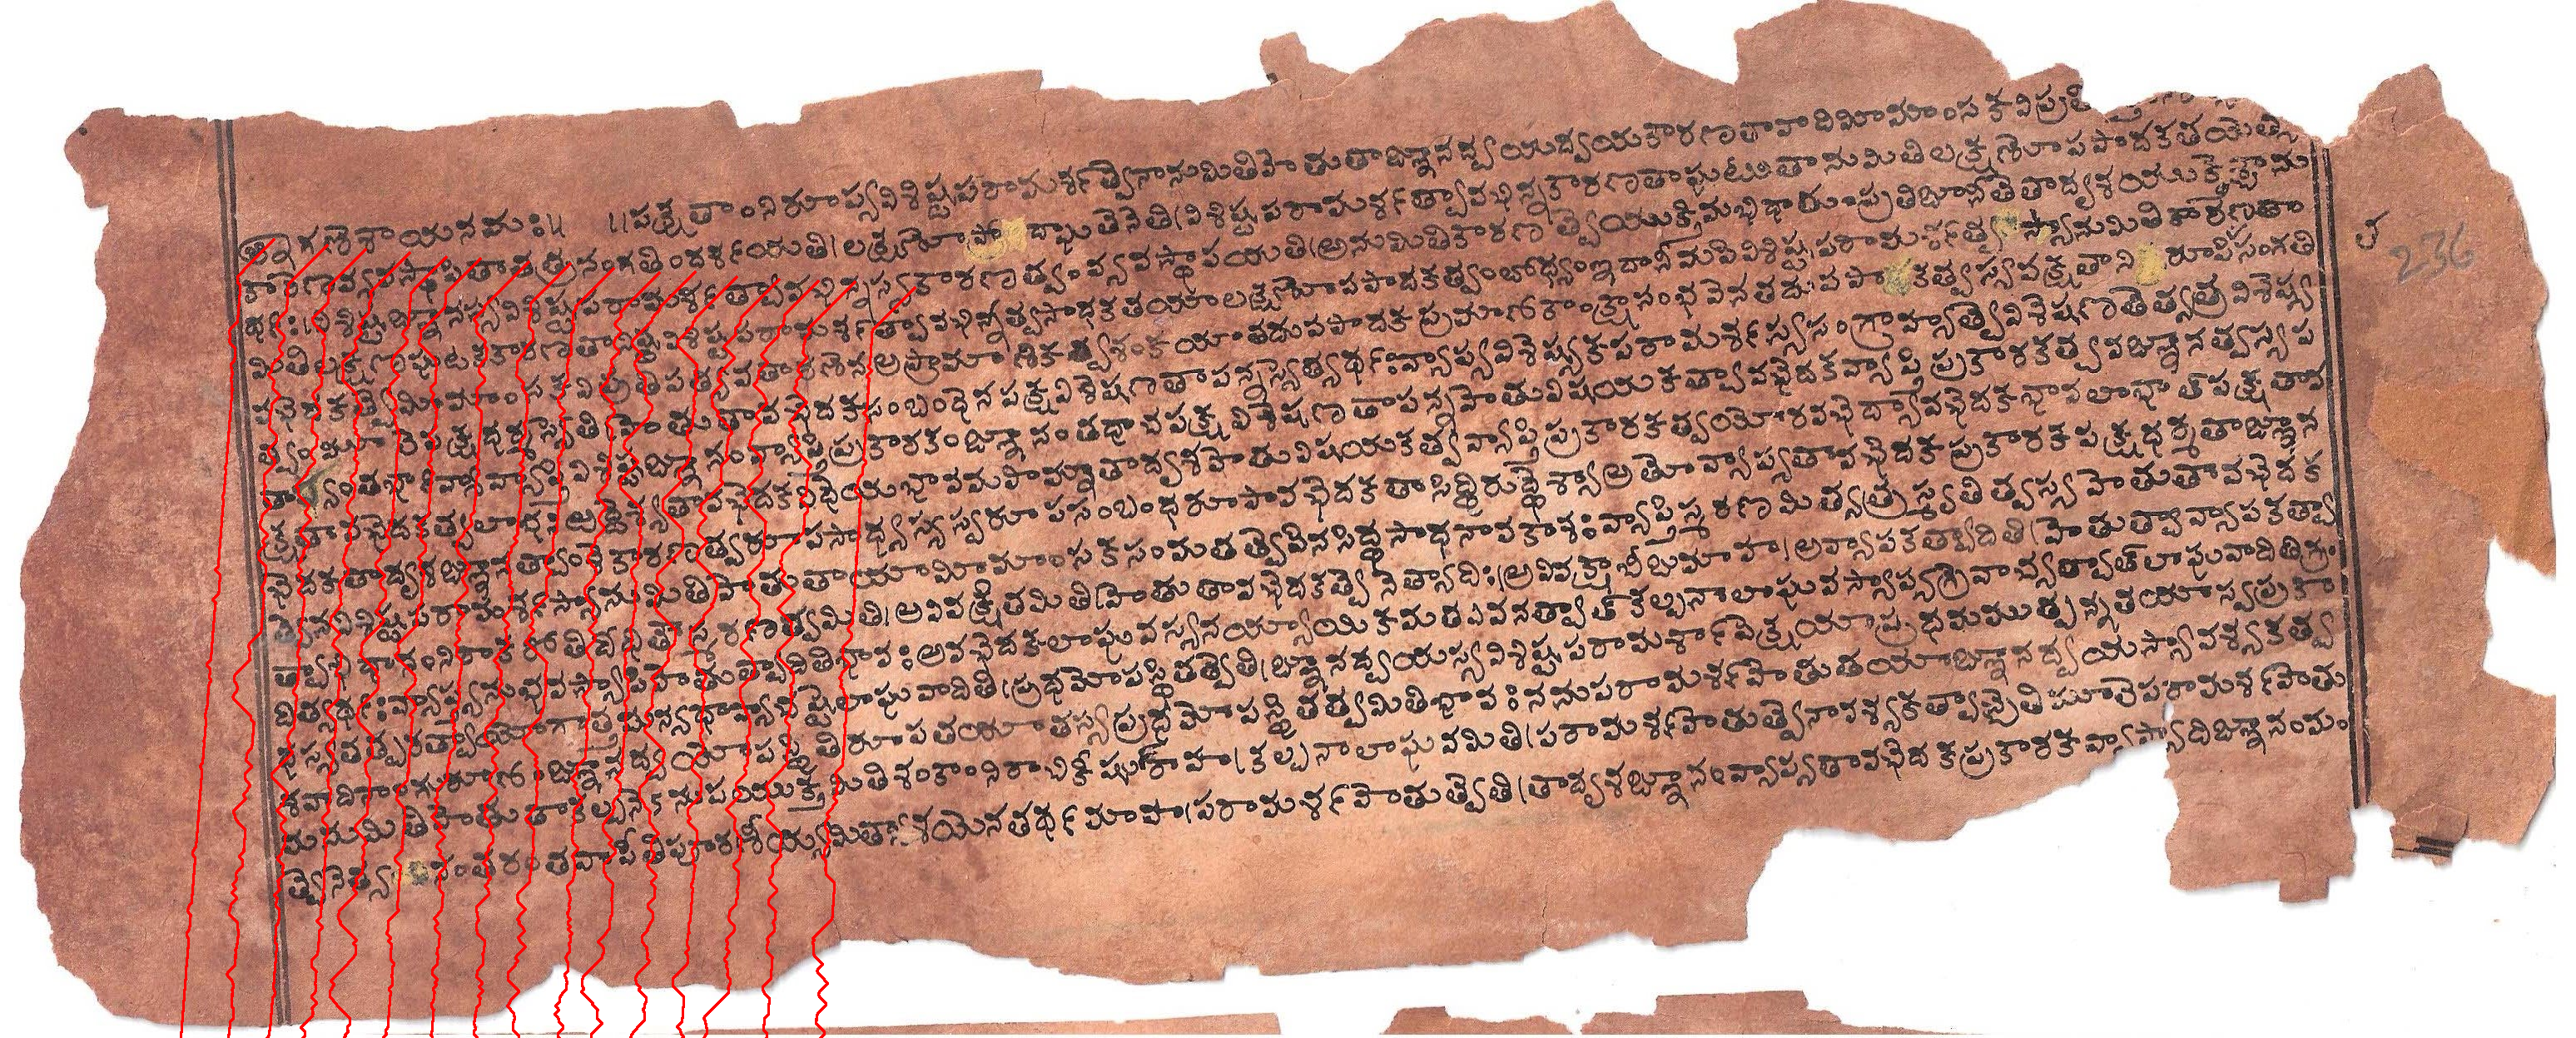

In [22]:
parentCanvas = copy.deepcopy(image)
for c in polys:
  c = np.asarray(c)
  parentCanvas = cv2.polylines(parentCanvas,[c],False,(0,0,255),2)

cv2_imshow(parentCanvas)